In [1]:
import chess
import chess.svg
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from IPython.display import display, Image ,clear_output
from stockfish import Stockfish
import tensorflow as tf

2023-09-30 21:52:43.286525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 21:52:44.302486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from copy import deepcopy

In [3]:
def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( ['--'] * int(c) )
            elif c == 'p':
                brow.append( 'bp' )
            elif c == 'P':
                brow.append( 'wp' )
            elif c > 'Z':
                brow.append( 'b'+c.upper() )
            else:
                brow.append( 'w'+c )

        board.append( brow )
    return board

In [4]:
class Envi():
    def __init__(self,intial_fen):
        self.stockfish=Stockfish("./stockfish-ubuntu-x86-64-avx2",parameters={"Hash":2048})
        self.stockfish.set_skill_level(7)
        if intial_fen == "":
            self.board = chess.Board()
        else:
            self.board = chess.Board(intial_fen)
            self.stockfish.set_fen_position(intial_fen)
        fen=self.board.fen()
        text=fen_to_board(fen)
        self.tokenizer=Tokenizer()
        self.tokenizer.fit_on_texts(text)
        self.movestack=[]
        self.movestack2=[]

    def step(self,action):
        r=50
        if len(self.movestack)>4:
            self.movestack.pop(0)
        if action in self.movestack:
            action=self.legal()[np.random.randint(len(self.legal()))]
        self.movestack.append(action)
        self.stockfish.set_fen_position(self.board.fen())
        self.board.push(action)
        if str(self.stockfish.will_move_be_a_capture(action.uci()).name)!="NO_CAPTURE":
            r=r+500
        self.stockfish.set_fen_position(self.board.fen())
        action=self.act_to_encod(action)
        self.boardprev=deepcopy(self.board)
        playermove=self.getbestmove()
        if playermove==None:
            return 200000,self.brd,1,action
        if str(self.stockfish.will_move_be_a_capture(playermove.uci()).name)!="NO_CAPTURE":
            r=r-500
        self.board.push(playermove)
        self.brd=self.state()
        # if self.boardprev.is_checkmate():
        #     return 10000,self.brd,1,action
        # elif self.boardprev.is_stalemate():
        #     return 10,self.brd,1,action
        # elif self.boardprev.is_insufficient_material():
        #     return 10,self.brd,1,action
        # elif self.boardprev.can_claim_draw():
        #     return 10,self.brd,1,action
        # elif self.boardprev.is_check():
        #     return 5000,self.brd,0,action
        # elif self.board.is_checkmate():
        #     return -500,self.brd,1,action
        # elif self.board.is_check():
        #     return -200,self.brd,0,action
        # else:
        #     return r,self.brd,0,action
        if self.boardprev.is_checkmate():
            return 1000000,self.brd,1,action
        elif self.boardprev.is_stalemate():
            return 10,self.brd,1,action
        elif self.boardprev.is_insufficient_material():
            return 10,self.brd,1,action
        elif self.boardprev.can_claim_draw():
            return 100,self.brd,1,action
        elif self.boardprev.is_check():
            return 3000,self.brd,0,action
        elif self.board.is_checkmate():
            return -200000,self.brd,1,action
        elif self.board.is_check():
            return -3000,self.brd,0,action
        # elif self.board.can_claim_threefold_repetition():
        #     return -10000,self.brd,1,action
        else:
            return r,self.brd,0,action
    
    def stepc(self,action):
        self.board.push(action)
        action=self.act_to_encod(action)
        self.brd=self.state()
        if self.board.is_checkmate():
            return 1000,self.brd,1,action
        if self.board.can_claim_threefold_repetition():
            return 10,self.brd,1,action
        elif self.board.is_stalemate():
            return 10,self.brd,1,action
        elif self.board.is_insufficient_material():
            return 10,self.brd,1,action
        elif self.board.can_claim_draw():
            return 10,self.brd,1,action
        elif self.board.is_check():
            return 10,self.brd,0,action
        else:
            return 0,self.brd,0,action
    
    def getbestmove(self):
        while not self.board.is_game_over():
            lmoves=self.legal()
            if len(lmoves)==0:
                return None
            else:
                q=[]
                for i in self.legal():
                    new_state=self.stepc2(i)
                    self.board.pop()
                    q.append(new_state)
                new_states=tf.convert_to_tensor(q,dtype=tf.float32)
                # new_states = np.expand_dims(new_states, axis=0)
                state_qn=player1(new_states)
                movep=self.legal()[np.argmax(state_qn)]
                if self.movestack2.count(movep)>3:
                    self.movestack2.pop(0)
                if movep in self.movestack2:
                    movep=self.legal()[np.random.randint(len(self.legal()))]
                self.movestack2.append(movep)
                print("Computer move",movep)
                return movep
    
    def stepc2(self,action):
        if action not in self.legal():
            print("Illegal move")
            return
        else:
            self.board.push(action)
            self.brd=self.state()
            return self.brd
    
    def act_to_encod(self,action):
        # move=chess.Move.from_uci(action)
        move=action
        return [move.from_square,move.to_square]
    
    def state(self):
        fen=self.board.fen()
        text=fen_to_board(fen)
        seq=self.tokenizer.texts_to_sequences(text)
        self.brd=np.array(seq).reshape(64)
        return self.brd
        
    def legal(self):
        self.pmoves=[x for x in self.board.legal_moves]
        return self.pmoves
    
    def evaluate(self,q_network):
        q=[]
        action=[]
        for i in self.legal():
            a,b,c,d=self.stepc(i)
            st=np.expand_dims(b,axis=0)
            st=tf.convert_to_tensor(st,dtype=tf.float32)
            q.append(q_network(st))
            action.append(i)
            self.board.pop()
        return q,action

    def reset(self):
        self.board.reset()
        return self.board.fen()

In [5]:
import tensorflow as tf
import numpy as np
import time
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple

In [6]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.75          # discount factor
ALPHA = 3e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
TAU = 1                # soft update of target parameters

In [7]:
frontmodel="ashtoyant-expi5.h5"

In [8]:
from tensorflow.keras.models import load_model
player1=load_model("ashtoyant-expi5.h5")

2023-09-30 21:52:46.182115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 21:52:46.307766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 21:52:46.307824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 21:52:46.309490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 21:52:46.309537: I tensorflow/compile

In [9]:
from tensorflow.keras.models import load_model
learnmodel=load_model("ashtoyant-expi5.h5")

In [10]:
# q_network = Sequential([
#     Input(shape=(64,)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.BatchNormalization(),
#     Dense(units=1024, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),                      
#     Dense(units=2048, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),
#     Dense(units=4096, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),           
#     Dense(units=128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),
#     Dense(units=32, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),           
#     Dense(units=1, activation='linear'),
#     ])

q_network=learnmodel

target_q_network = Sequential([
    Input(shape=(64,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    Dense(units=1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),                      
    Dense(units=2048, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),           
    Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),           
    Dense(units=1, activation='linear'),
    ])

# q_network = Sequential([
#     Input(shape=(66,)),
#     tf.keras.layers.Reshape((11,6)),
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),                      
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),            
#     Dense(units=32, activation='relu'),            
#     Dense(units=1, activation='linear'),
#     ])

# q_network=model

# target_q_network = Sequential([
#     Input(shape=(66,)),
#     tf.keras.layers.Reshape((11,6)),
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),                      
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),            
#     Dense(units=32, activation='relu'),            
#     Dense(units=1, activation='linear'),
#     ])


optimizer =Adam(learning_rate=ALPHA)

In [11]:
q_network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 batch_normalization_12 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_13 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 2048)             

In [12]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [13]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    states,rewards, next_states, done_vals,actions = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets =rewards + (gamma * max_qsa * (1 - done_vals))
    q_values = q_network(states)
    # q_values = tf.gather_nd(q_values,tf.concat((next_states,actions),axis=1))    
    loss = MSE(y_targets, q_values)
    print("  Loss :-",loss)
    
    return loss

In [14]:
@tf.function
def agent_learn(experiences, gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # for target_weights, q_net_weights in zip(
    #     target_q_network.weights, q_network.weights
    # ):
    #     target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [15]:
@tf.function
def update_agent():
    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [16]:
num_games=10000
num_moves=50

total_point_history = []
total_step_history = []

num_p_av=10
epsilon=0
mini_batch_size=512

learning_interval=5

target_q_network.set_weights(q_network.get_weights())

In [17]:
def getaction(env,epsilon):
    if np.random.rand() < epsilon and len(env.legal()) > 0:
        return env.legal()[np.random.randint(len(env.legal()))]
    else:
        q = []
        for i in env.legal():
            da1,new_state,da2,action=env.stepc(i)
            # state_qn = np.concatenate((env.state(),action),axis=None)
            state_qn=np.expand_dims(env.state(),axis=0)
            env.board.pop()
            q.append(q_network(state_qn))
        if q == []:
            return None
        else:
            return env.legal()[np.argmax(q)]
    

In [18]:
def qupdate(t):
    if t % learning_interval == 0:
        return True
    else:
        return False
        

In [19]:
def get_experiences(mem):
    min=mini_batch_size
    try:
        batch=random.sample(mem,min)
    except:
        min=5
        batch=random.sample(mem,min)
    states=np.zeros((min,64))
    rewards=np.zeros(min)
    next_states=np.zeros((min,64)) 
    done_vals=np.zeros(min)
    action=np.zeros((min,2))
    for i in range(min):
        # print('\n')
        # print(i)
        # print('\n')
        # print(batch[i])
        states[i]=batch[i][0]
        rewards[i]=batch[i][1]
        next_states[i]=batch[i][2]
        done_vals[i]=batch[i][3]
        action[i]=batch[i][4]
    cbatch=(tf.convert_to_tensor(states,dtype=tf.float32),
            tf.convert_to_tensor(rewards,dtype=tf.float32),
            tf.convert_to_tensor(next_states,dtype=tf.float32),
            tf.convert_to_tensor(done_vals,dtype=tf.float32),
            tf.convert_to_tensor(action,dtype=tf.float32))
    return cbatch

In [20]:
def get_new_eps(eps):
    eps=eps*0.95
    # if eps < 0.3:
    #     return 0.3
    return eps

In [21]:
import matplotlib.pyplot as plt

[5800, 17100, 16150, 10800, 600, 15200, 5800, 0, 5800, 10850]

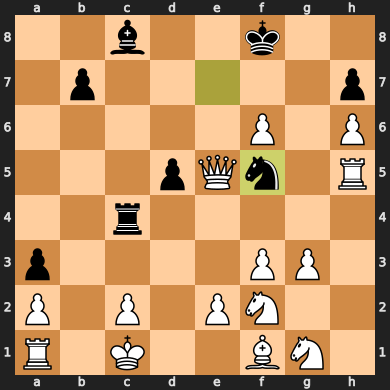

Episode 32 | Step 42 | last move point 50

KeyboardInterrupt: 

In [22]:
memory_buffer=deque(maxlen=MEMORY_SIZE)
for i in range(num_games):
    # if i/2 == 0:
    #     env=Envi("rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1")
    #     co=-1
    # else:
    #     env=Envi("")
    #     co=1
    env=Envi("")
    total_points=0
    reward=0
    epsilon=0.5

    if i % 50 == 0:
        update_agent()
        epsilon=0.5

    for t in range(1,num_moves):
        state=env.state()
        print(f"\rEpisode {i+1} | Step {t} | last move point {reward}", end="")
        action=getaction(env,epsilon)
        if action==None:
            break
        reward,next_state,done,action=env.step(action)
        # reward=reward*co
        # memory_buffer.append((state,action,reward,next_state,done))
        # if  t==20 or t==25 or t==30 or t==35 or t==40 or t==45:
        #     reward=reward-20000
        memory_buffer.append([state,reward,next_state,done,action])

        update=qupdate(t)

        if update:
            experiences=get_experiences(memory_buffer)

            agent_learn(experiences,GAMMA)

        clear_output()
        display(total_point_history[-10:])
        display(env.board)
        
        state=next_state
        total_points+=reward

        if done:
            env.board.outcome()
            total_step_history.append(t)
            break

    epsilon=get_new_eps(epsilon)
    
    total_point_history.append(total_points)
    av_latest_points=np.mean(total_point_history[-20:])
    env.board.outcome()

    # epsilon=get_new_eps(epsilon)

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        q_network.save(frontmodel)
        target_q_network.set_weights(q_network.get_weights())

    if av_latest_points >=300000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save(frontmodel)
        break

In [23]:
import utils

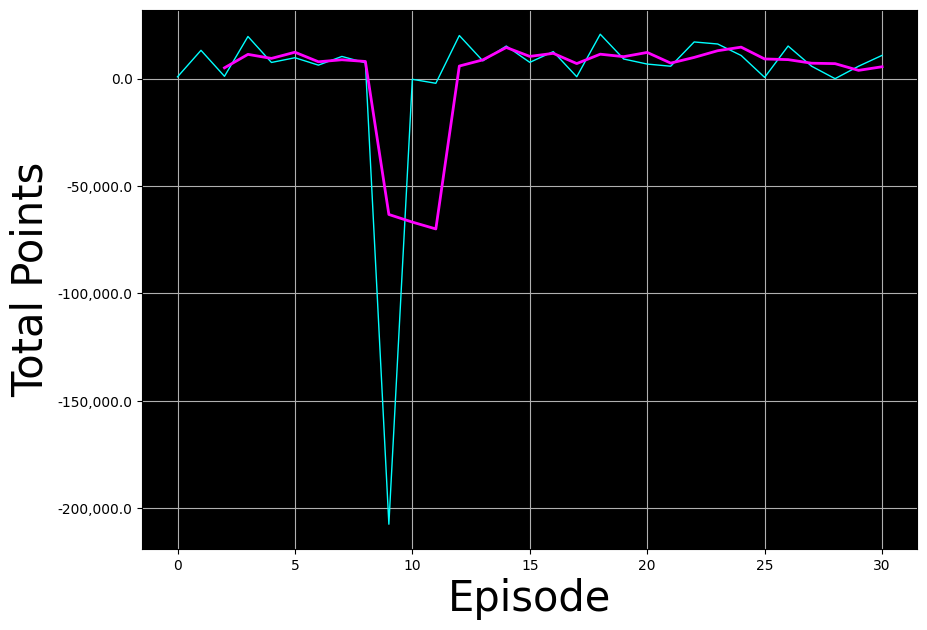

In [24]:
utils.plot_history(total_point_history)

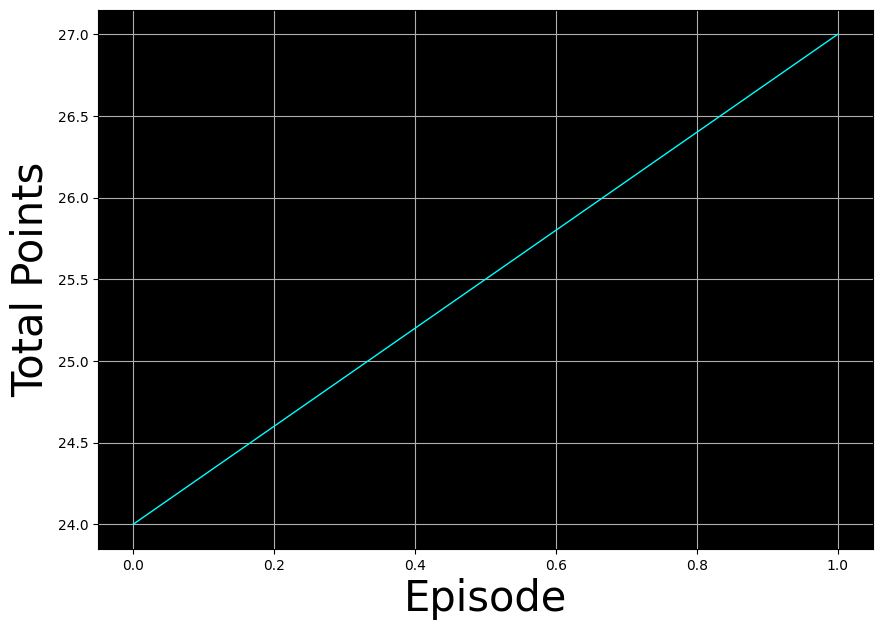

In [25]:
utils.plot_history(total_step_history)

In [26]:
update_agent()

In [27]:
q_network.save(frontmodel)

In [ ]:
import pickle
with open('tokenizer_data.pkl','wb') as f:
    pickle.dump({'tokenizer':env.tokenizer},f)